# Data Processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")

# Load datasets
train = pd.read_csv("/kaggle/input/smokerstatusdata/train_dataset.csv")
test = pd.read_csv("/kaggle/input/smokerstatusdata/test_dataset.csv")

In [2]:
def preprocess_dataset(train_df, test_df=None):

    print("============== 1. INITIAL DATASET SHAPE ==============")
    print("Train:", train_df.shape)
    if test_df is not None:
        print("Test:", test_df.shape)

    # Work on copies to avoid modifying original data
    train_df = train_df.copy()
    test_df = test_df.copy() if test_df is not None else None

    # -----------------------------------------------------------------
    # 2. REMOVE DUPLICATES
    # -----------------------------------------------------------------
    print("\n============== 2. DUPLICATE REMOVAL ==============")
    before = train_df.shape[0]
    train_df.drop_duplicates(inplace=True)
    removed = before - train_df.shape[0]
    print(f"Removed {removed} duplicates")

    # -----------------------------------------------------------------
    # 3. MISSING VALUE IMPUTATION
    # -----------------------------------------------------------------
    print("\n============== 3. MISSING VALUE IMPUTATION ==============")

    # Compute train statistics once
    train_medians = train_df.select_dtypes(include=['int64','float64']).median()
    train_modes = train_df.select_dtypes(include=['object']).mode().iloc[0] \
                    if not train_df.select_dtypes(include=['object']).empty else {}

    # Impute train
    for col in train_df.columns:
        if train_df[col].dtype != "object":
            train_df[col].fillna(train_medians[col], inplace=True)
        else:
            train_df[col].fillna(train_modes[col], inplace=True)

    # Impute test (using train statistics)
    if test_df is not None:
        for col in test_df.columns:
            if col in train_df.columns:
                if test_df[col].dtype != "object":
                    test_df[col].fillna(train_medians[col], inplace=True)
                else:
                    test_df[col].fillna(train_modes[col], inplace=True)

    # -----------------------------------------------------------------
    # 4. DATA TYPES
    # -----------------------------------------------------------------
    print("\n============== 4. DATA TYPES ==============")
    numeric_cols = train_df.select_dtypes(include=['int64','float64']).columns.tolist()
    categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
    print("Numeric:", numeric_cols)
    print("Categorical:", categorical_cols)

    # -----------------------------------------------------------------
    # 5. LABEL ENCODING (BINARY ONLY)
    # -----------------------------------------------------------------
    print("\n============== 5. LABEL ENCODING (BINARY) ==============")
    label_encoders = {}

    for col in categorical_cols:
        if train_df[col].nunique() == 2:
            le = LabelEncoder()
            train_df[col] = le.fit_transform(train_df[col])
            label_encoders[col] = le
            print("Binary encoded:", col)

            if test_df is not None:
                # Handle unseen labels safely
                test_df[col] = test_df[col].apply(lambda x: x if x in le.classes_ else le.classes_[0])
                test_df[col] = le.transform(test_df[col])

    # -----------------------------------------------------------------
    # 6. ONE-HOT ENCODING (MULTI-CLASS)
    # -----------------------------------------------------------------
    print("\n============== 6. ONE-HOT ENCODING ==============")

    multi_cat = [c for c in categorical_cols if train_df[c].nunique() > 2]

    train_df = pd.get_dummies(train_df, columns=multi_cat, drop_first=True)

    if test_df is not None:
        test_df = pd.get_dummies(test_df, columns=multi_cat, drop_first=True)
        # Match columns between train & test
        test_df = test_df.reindex(columns=train_df.columns, fill_value=0)

    # -----------------------------------------------------------------
    # 7. FEATURE SCALING — STANDARD SCALER
    # -----------------------------------------------------------------
    print("\n============== 7. FEATURE SCALING ==============")

    scaler = StandardScaler()

    numeric_final = train_df.select_dtypes(include=['int64','float64']).columns

    train_df[numeric_final] = scaler.fit_transform(train_df[numeric_final])

    if test_df is not None:
        test_df[numeric_final] = scaler.transform(test_df[numeric_final])

    # -----------------------------------------------------------------
    # 8. SUMMARY
    # -----------------------------------------------------------------
    print("\n============== FINAL DATASET SUMMARY ==============")
    print("Train shape:", train_df.shape)
    if test_df is not None:
        print("Test shape:", test_df.shape)
    print("Columns:", len(train_df.columns))
    print("===================================================")

    return train_df, test_df, scaler, label_encoders


train_processed, test_processed, scaler, encoders = preprocess_dataset(train, test)


============== 1. INITIAL DATASET SHAPE ==============
Train: (38984, 23)
Test: (16708, 22)

============== 2. DUPLICATE REMOVAL ==============
Removed 5517 duplicates

============== 3. MISSING VALUE IMPUTATION ==============

============== 4. DATA TYPES ==============
Numeric: ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries', 'smoking']
Categorical: []

============== 5. LABEL ENCODING (BINARY) ==============

============== 6. ONE-HOT ENCODING ==============

============== 7. FEATURE SCALING ==============

============== FINAL DATASET SUMMARY ==============
Train shape: (33467, 23)
Test shape: (16708, 23)
Columns: 23


# EDA

## 1. SETUP + BMI FEATURE

In [3]:
df = train.copy()  
df["height_m"] = df["height(cm)"] / 100
df["BMI"] = df["weight(kg)"] / (df["height_m"] ** 2)


## 2. BASIC DISTRIBUTION PLOTS

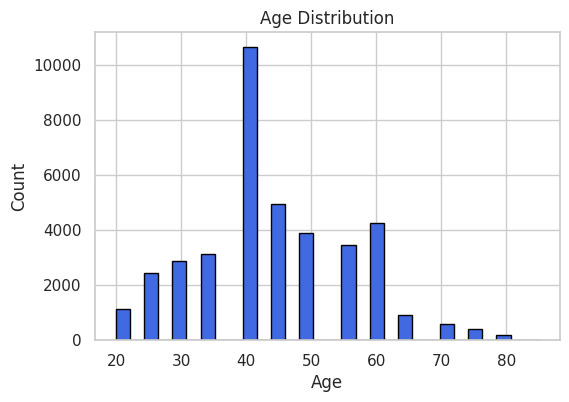

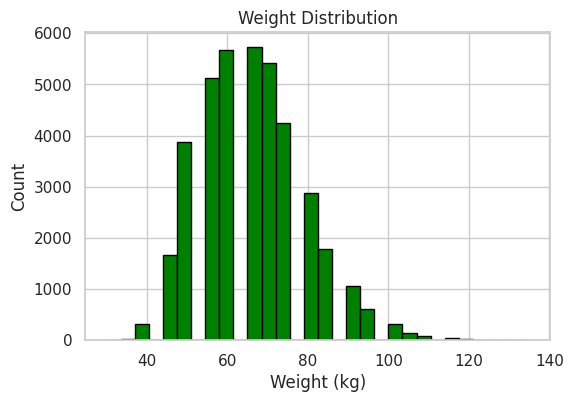

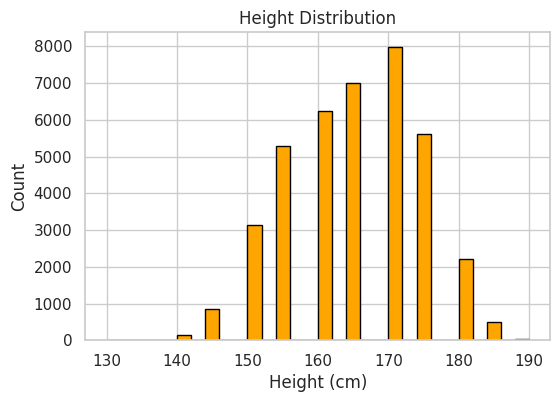

In [4]:
plt.figure(figsize=(6,4))
plt.hist(df["age"], bins=30, color="royalblue", edgecolor="black")
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df["weight(kg)"], bins=30, color="green", edgecolor="black")
plt.title("Weight Distribution")
plt.xlabel("Weight (kg)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df["height(cm)"], bins=30, color="orange", edgecolor="black")
plt.title("Height Distribution")
plt.xlabel("Height (cm)")
plt.ylabel("Count")
plt.show()


## 3. MULTI-COLOR SCATTER PLOTS (Color by Age)

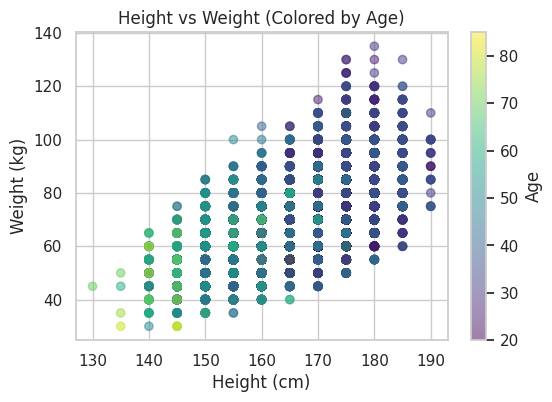

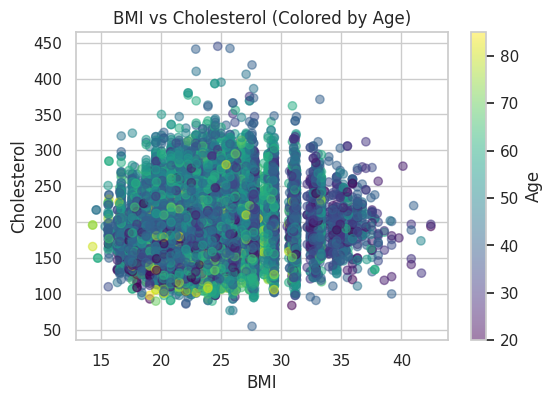

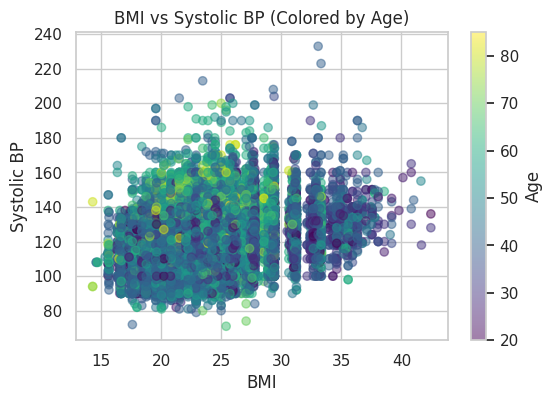

In [5]:
plt.figure(figsize=(6,4))
plt.scatter(df["height(cm)"], df["weight(kg)"], c=df["age"], cmap="viridis", alpha=0.5)
plt.colorbar(label="Age")
plt.title("Height vs Weight (Colored by Age)")
plt.xlabel("Height (cm)")
plt.ylabel("Weight (kg)")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(df["BMI"], df["Cholesterol"], c=df["age"], cmap="viridis", alpha=0.5)
plt.colorbar(label="Age")
plt.title("BMI vs Cholesterol (Colored by Age)")
plt.xlabel("BMI")
plt.ylabel("Cholesterol")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(df["BMI"], df["systolic"], c=df["age"], cmap="viridis", alpha=0.5)
plt.colorbar(label="Age")
plt.title("BMI vs Systolic BP (Colored by Age)")
plt.xlabel("BMI")
plt.ylabel("Systolic BP")
plt.show()


## 4. KDE DENSITY PLOTS (SMOKERS vs NON-SMOKERS)


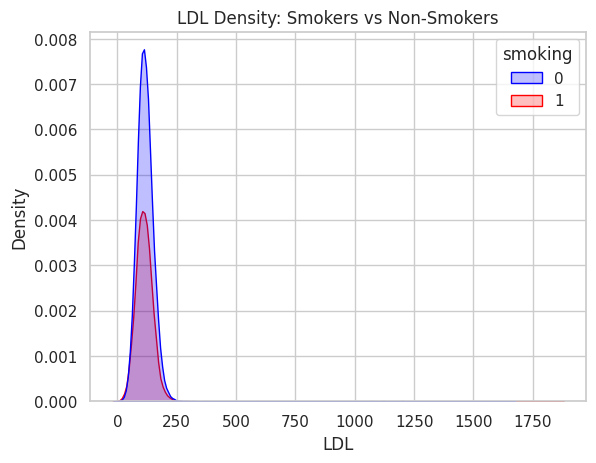

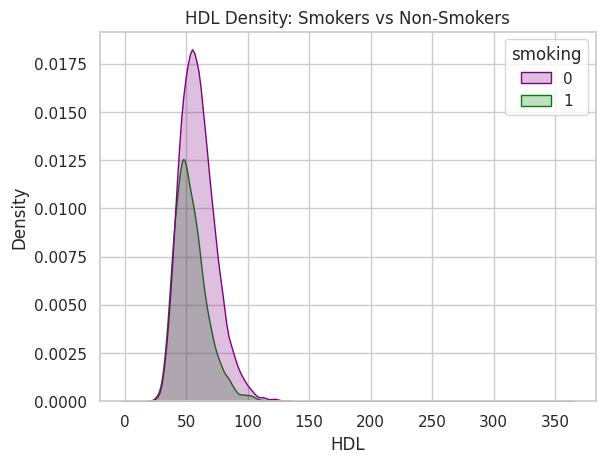

In [6]:
sns.kdeplot(data=df, x="LDL", hue="smoking", fill=True, palette=["blue", "red"])
plt.title("LDL Density: Smokers vs Non-Smokers")
plt.show()

sns.kdeplot(data=df, x="HDL", hue="smoking", fill=True, palette=["purple", "green"])
plt.title("HDL Density: Smokers vs Non-Smokers")
plt.show()

## 5. BOXPLOTS ACROSS AGE GROUPS

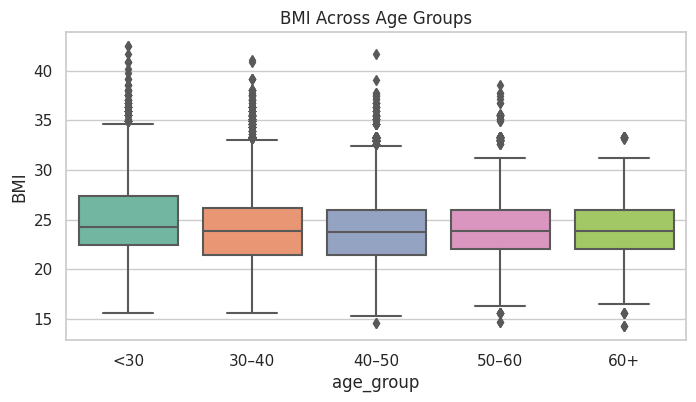

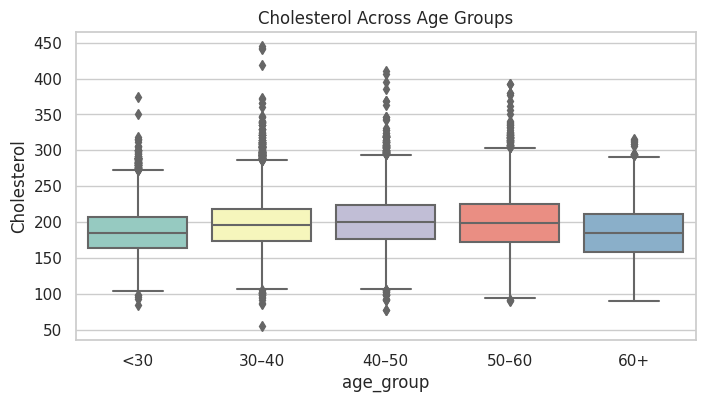

In [7]:
df["age_group"] = pd.cut(df["age"], bins=[0,30,40,50,60,120],
                         labels=["<30","30–40","40–50","50–60","60+"])


plt.figure(figsize=(8,4))
sns.boxplot(x="age_group", y="BMI", data=df, palette="Set2")
plt.title("BMI Across Age Groups")
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x="age_group", y="Cholesterol", data=df, palette="Set3")
plt.title("Cholesterol Across Age Groups")
plt.show()


## 6. CORRELATION HEATMAP (WITH NUMERIC VALUES)

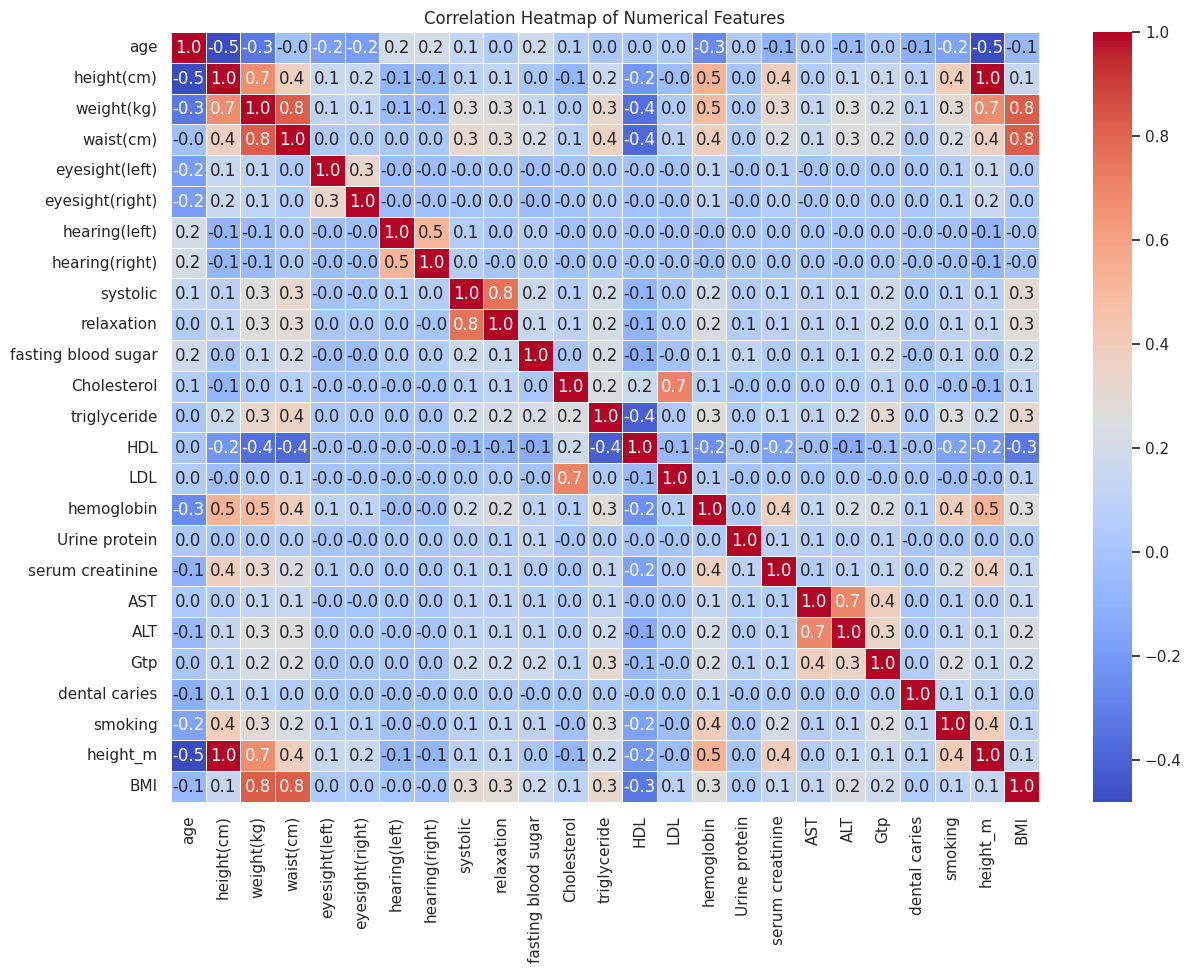

In [8]:
num_cols = df.select_dtypes(include=["int64","float64"]).columns

plt.figure(figsize=(14,10))
corr = df[num_cols].corr()

sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=True,    # numeric values
    fmt=".1f",
    linewidths=0.5
)

plt.title("Correlation Heatmap of Numerical Features")
plt.show()


## 7. PAIRPLOT (KEY VARIABLES)

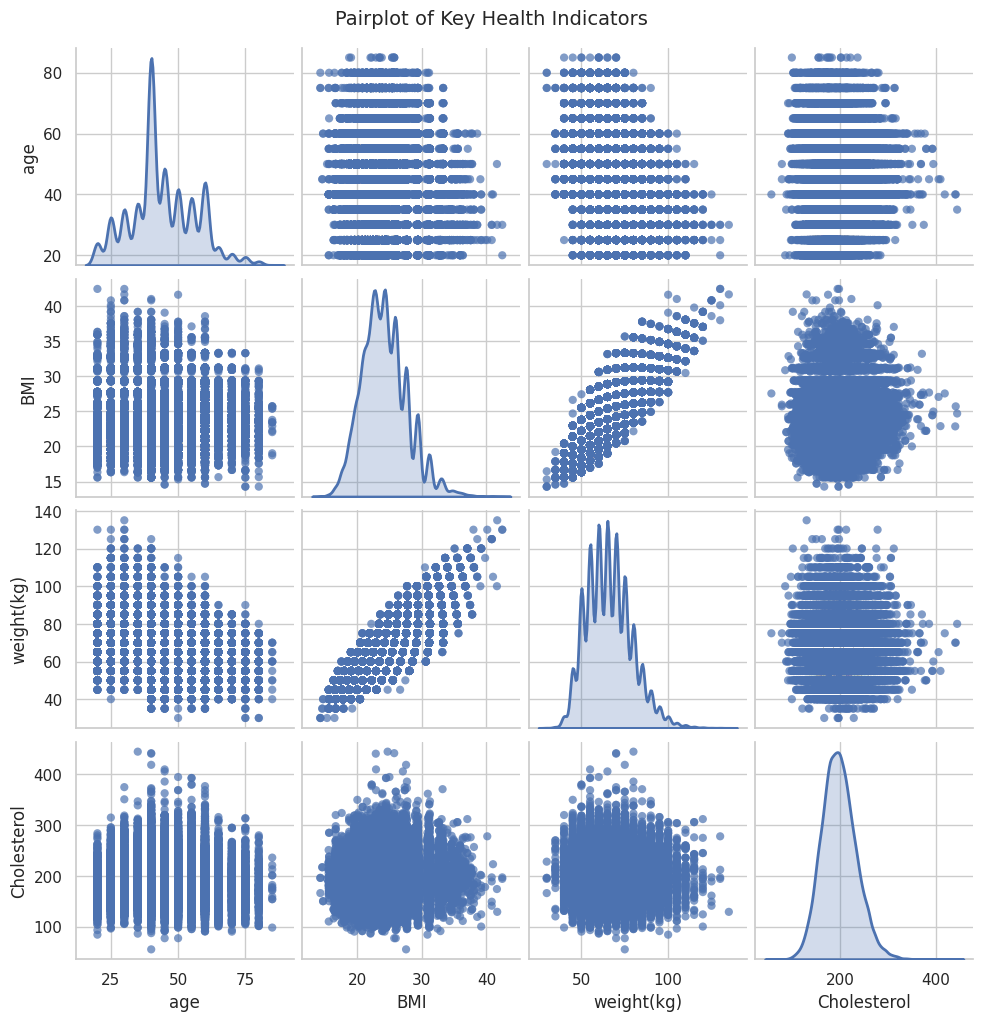

In [9]:
# Improved pairplot styling (same code structure, only better colors)


sns.set_theme(style="whitegrid")

# Better gradient palette
palette = sns.color_palette("coolwarm", as_cmap=True)

pair_df = df[["age", "BMI", "weight(kg)", "Cholesterol"]].apply(pd.to_numeric, errors="coerce")
pair_df = pair_df.dropna()

sns.pairplot(
    pair_df,
    diag_kind="kde",
    palette="coolwarm",
    plot_kws={"alpha": 0.7, "s": 35, "edgecolor": "none"},
    diag_kws={"linewidth": 2}
)

plt.suptitle("Pairplot of Key Health Indicators", y=1.02, fontsize=14)
plt.show()


## 8. SMOKERS VS NON-SMOKERS CORRELATION DIFFERENCE

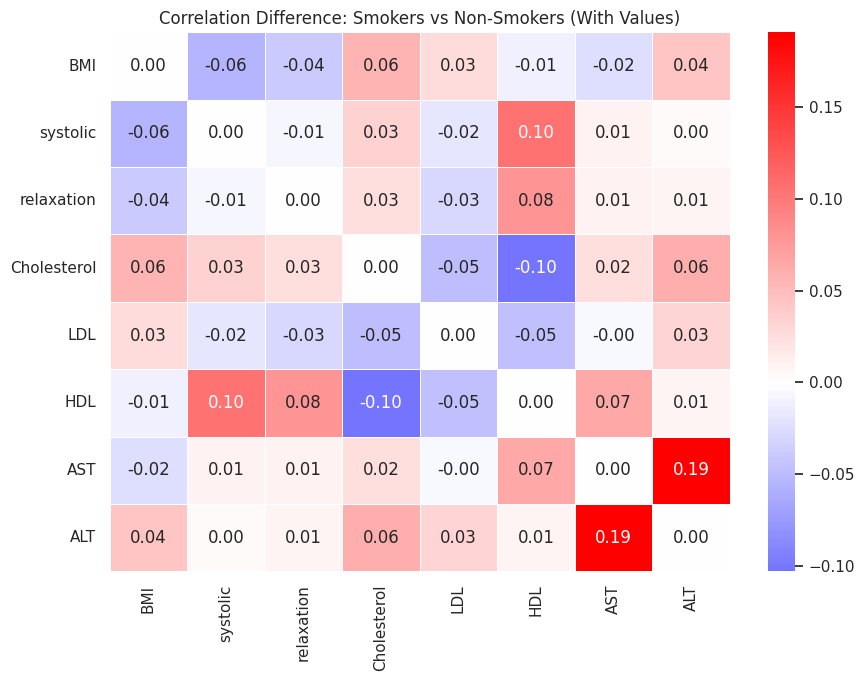

In [10]:
smokers = df[df["smoking"] == 1]
nonsmokers = df[df["smoking"] == 0]

impact_cols = ["BMI","systolic","relaxation","Cholesterol","LDL","HDL","AST","ALT"]

corr_diff = smokers[impact_cols].corr() - nonsmokers[impact_cols].corr()

plt.figure(figsize=(10,7))
sns.heatmap(
    corr_diff,
    cmap="bwr",
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Difference: Smokers vs Non-Smokers (With Values)")
plt.show()
